In [ ]:
import math

# --- Constants for the SR501/B03 Sensor ---
R_FIXED = 10000.0     # Fixed resistor value in Ohms
ADC_MAX = 4095.0      # 12-bit ADC maximum value

# --- NTC Thermistor Parameters [12] ---
BETA = 3950.0         # Beta constant in K
R0 = 10000.0          # Nominal resistance at T0 in Ohms
T0_KELVIN = 298.15    # Nominal temperature in Kelvin (25 C)
KELVIN_TO_C = 273.15  # Conversion factor from Kelvin to Celsius

def convert_adc_to_celsius(adc_val: int) -> float:
    """
    Converts a raw 12-bit ADC value from the SR501/B03 sensor to temperature.

    Args:
        adc_val: The raw 12-bit integer value (0-4095) from the sensor.

    Returns:
        The calculated temperature in degrees Celsius.
    """
    if not (0 < adc_val < ADC_MAX):
        # Handle out-of-range values to prevent math errors.
        return float('nan')

    # Step 1: Convert ADC value to thermistor resistance (R_th)
    r_th = R_FIXED * ((ADC_MAX / adc_val) - 1.0)

    # Step 2: Convert thermistor resistance to temperature in Kelvin (T)
    log_r_th_div_r0 = math.log(r_th / R0)
    t_inv = (1.0 / T0_KELVIN) + (1.0 / BETA) * log_r_th_div_r0
    t_kelvin = 1.0 / t_inv

    # Step 3: Convert Kelvin to Celsius
    temp_c = t_kelvin - KELVIN_TO_C

    return temp_c

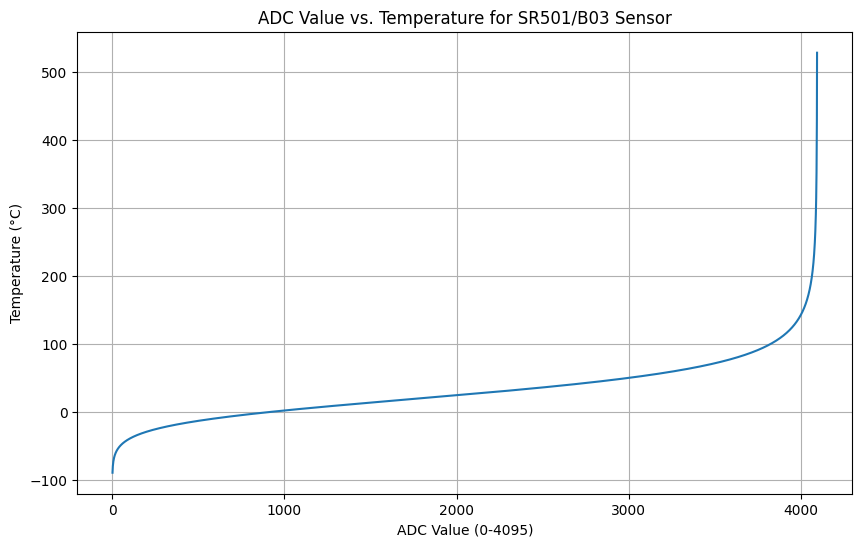

In [ ]:
# prompt: Plot the results of evaluating convert_adc_to_celsius from 0 to 0xfff

import matplotlib.pyplot as plt
import numpy as np

# Generate ADC values from 1 to 0xfff (4095), excluding 0
adc_values = np.arange(1, 0xfff + 1)

# Calculate Celsius temperatures for each ADC value
celsius_temperatures = [convert_adc_to_celsius(adc) for adc in adc_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(adc_values, celsius_temperatures)
plt.xlabel('ADC Value (0-4095)')
plt.ylabel('Temperature (°C)')
plt.title('ADC Value vs. Temperature for SR501/B03 Sensor')
plt.grid(True)
plt.show()

/tmp/ipython-input-5-472470654.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(piecewise_linear, adc_filtered, celsius_filtered, p0=p0)


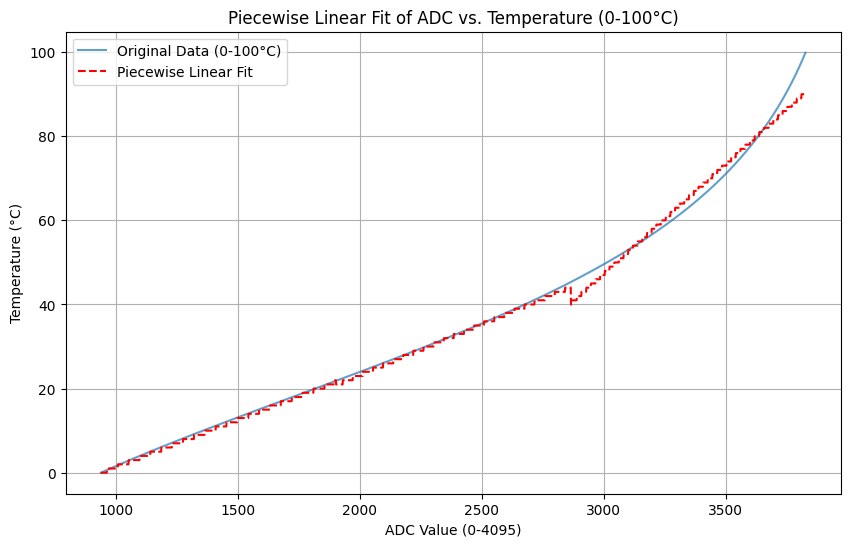

Fitted Parameters:
  Segment 1: Slope=0.0224, Intercept=-20.6125, Breakpoint 1 (ADC)=1902.00
  Segment 2: Slope=0.0241, Intercept=-24.5974, Breakpoint 2 (ADC)=2865.00
  Segment 3: Slope=0.0521, Intercept=-108.6767


In [ ]:
# prompt: fit the output of the previous plot with a three part linear function (only between 0 to 100c temperatures), plot the fited results with the original function. Only plot 0-100c

from scipy.optimize import curve_fit

def piecewise_linear(x, a1, b1, c1, a2, b2, c2, a3, b3):
    """Three-part piecewise linear function."""
    y = np.piecewise(x, [x < c1, (x >= c1) & (x < c2), x >= c2],
                     [lambda x: a1 * x + b1,
                      lambda x: a2 * x + b2,
                      lambda x: a3 * x + b3])
    return y

# Filter data to the temperature range 0 to 100 C
filtered_indices = np.where((np.array(celsius_temperatures) >= 0) & (np.array(celsius_temperatures) <= 100))[0]
adc_filtered = adc_values[filtered_indices]
celsius_filtered = np.array(celsius_temperatures)[filtered_indices]

# Initial guess for the parameters (slopes, intercepts, and break points)
# We need 8 parameters for a three-part linear function
# Initial guesses for break points can be based on roughly dividing the ADC range
initial_c1 = adc_filtered[int(len(adc_filtered) * 1/3)]
initial_c2 = adc_filtered[int(len(adc_filtered) * 2/3)]

# Initial guesses for slopes and intercepts can be estimated from the data
# Using polyfit on sections as an initial guess
p1 = np.polyfit(adc_filtered[adc_filtered < initial_c1], celsius_filtered[adc_filtered < initial_c1], 1)
p2 = np.polyfit(adc_filtered[(adc_filtered >= initial_c1) & (adc_filtered < initial_c2)], celsius_filtered[(adc_filtered >= initial_c1) & (adc_filtered < initial_c2)], 1)
p3 = np.polyfit(adc_filtered[adc_filtered >= initial_c2], celsius_filtered[adc_filtered >= initial_c2], 1)

p0 = [p1[0], p1[1], initial_c1, p2[0], p2[1], initial_c2, p3[0], p3[1]]

# Fit the piecewise linear function to the filtered data
params, cov = curve_fit(piecewise_linear, adc_filtered, celsius_filtered, p0=p0)

# Extract the fitted parameters
a1_fit, b1_fit, c1_fit, a2_fit, b2_fit, c2_fit, a3_fit, b3_fit = params

# Generate fitted temperature values over the filtered ADC range
celsius_fitted = piecewise_linear(adc_filtered, *params)

# Plotting the original data (0-100 C) and the fitted piecewise linear function
plt.figure(figsize=(10, 6))
plt.plot(adc_filtered, celsius_filtered, label='Original Data (0-100°C)', alpha=0.7)
plt.plot(adc_filtered, celsius_fitted, label='Piecewise Linear Fit', color='red', linestyle='--')
plt.xlabel('ADC Value (0-4095)')
plt.ylabel('Temperature (°C)')
plt.title('Piecewise Linear Fit of ADC vs. Temperature (0-100°C)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted Parameters:")
print(f"  Segment 1: Slope={a1_fit:.4f}, Intercept={b1_fit:.4f}, Breakpoint 1 (ADC)={c1_fit:.2f}")
print(f"  Segment 2: Slope={a2_fit:.4f}, Intercept={b2_fit:.4f}, Breakpoint 2 (ADC)={c2_fit:.2f}")
print(f"  Segment 3: Slope={a3_fit:.4f}, Intercept={b3_fit:.4f}")